In [27]:
from pathlib import Path
from LHC_FillingPattern import LHCFillingPattern 
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import pandas as pd
from matplotlib.lines import Line2D
from scipy.integrate import cumtrapz 

In [28]:
DATADIR = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363""/HX:FILLN=10739/")
df = pd.read_parquet(DATADIR)   

In [ ]:
ATLAS_PV = "ATLAS:BUNCH_LUMI_INST" 
CMS_PV = 'CMS:BUNCH_LUMI_INST'
BETASTAR_PV = 'HX:BETASTAR_IP1'#, HX:BETASTAR_IP2', 'HX:BETASTAR_IP5', 'HX:BETASTAR_IP8'
XING_PV = 'LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value'
LUMI_B1_PV = "LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY"
LUMI_B2_PV = "LHC.BCTFR.B6R4.B2:BUNCH_INTENSITY"
EMIT_H_B1_PV = "LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_H"
EMIT_H_B2_PV = "LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_H"   
EMIT_V_B1_PV = "LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_V"  
EMIT_V_B2_PV  =  "LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_V"   

In [30]:
BUNCH_GROUPS = {
    "q = 1"  : ([20, 500],    "green"),
    "q = 1.5": ([1250, 1800], "red"),
}
SOLO_BID = 2874  # plotted in black
group_defs = {
    "q = 1": BUNCH_GROUPS["q = 1"][0],
    "q = 1.5": BUNCH_GROUPS["q = 1.5"][0],
    f"BID {SOLO_BID}": [SOLO_BID],
}
colours = {"q = 1": "green", "q = 1.5": "red", f"BID {SOLO_BID}": "black"}

In [36]:
def load_bunch_array(pv_name: str, bid_list):
    """
    Load raw bunch array from Parquet, drop NaNs, and return DataFrame
    with datetime index (ns -> UTC) and selected bunch columns.
    """
    raw = (
        dd.read_parquet(DATADIR, columns=[pv_name])
          .dropna()
          .compute()
    )
    raw.index = pd.to_datetime(raw.index, unit="ns")
    raw.sort_index(inplace=True)
    mat = np.stack(raw[pv_name].values)
    sliced = mat[:, bid_list]
    df = pd.DataFrame(
        sliced,
        index=raw.index,
        columns=[f"B{bid}" for bid in bid_list]
    )
    # drop rows where all selected bunches are NaN, round to 1-second grid
    df.dropna(how="all", inplace=True)
    df.index = df.index.round("S")
    return df

def load_scalar_series(pv_name: str):
    """
    Load scalar PV, drop NaNs, and resample to 1-second bins by mean.
    """
    raw = (
        dd.read_parquet(DATADIR, columns=[pv_name])
          .dropna()
          .compute()
    )
    raw.index = pd.to_datetime(raw.index, unit="ns")
    raw.sort_index(inplace=True)
    return raw[pv_name].astype(float).resample("1S").mean()
dynamic_ylim = True 
all_bids = [*BUNCH_GROUPS["q = 1"][0], *BUNCH_GROUPS["q = 1.5"][0], SOLO_BID]

## Luminosity

In [37]:
# --- Load and clean bunch-by-bunch luminosities
df_atlas = load_bunch_array(ATLAS_PV, all_bids)
df_cms   = load_bunch_array(CMS_PV,   all_bids)

# Drop rows where all bunch values are NaN and round to 1-second grid
for df in (df_atlas, df_cms):
    df.dropna(how="all", inplace=True)
    df.index = df.index.round("S")

# Build common time grid
t0 = min(df_atlas.index.min(), df_cms.index.min())
t1 = max(df_atlas.index.max(), df_cms.index.max())
time_grid = pd.date_range(t0, t1, freq="1S")

# Reindex and interpolate both separately
atlas_sync = (df_atlas.reindex(time_grid).interpolate(method="time").ffill().bfill())
cms_sync = (df_cms.reindex(time_grid).interpolate(method="time").ffill().bfill())

beta_1s = load_scalar_series(BETASTAR_PV)
xing_1s = load_scalar_series(XING_PV)
beta_sync = beta_1s.reindex(time_grid).interpolate(method="time").ffill().bfill()
xing_sync = xing_1s.reindex(time_grid).interpolate(method="time").ffill().bfill()


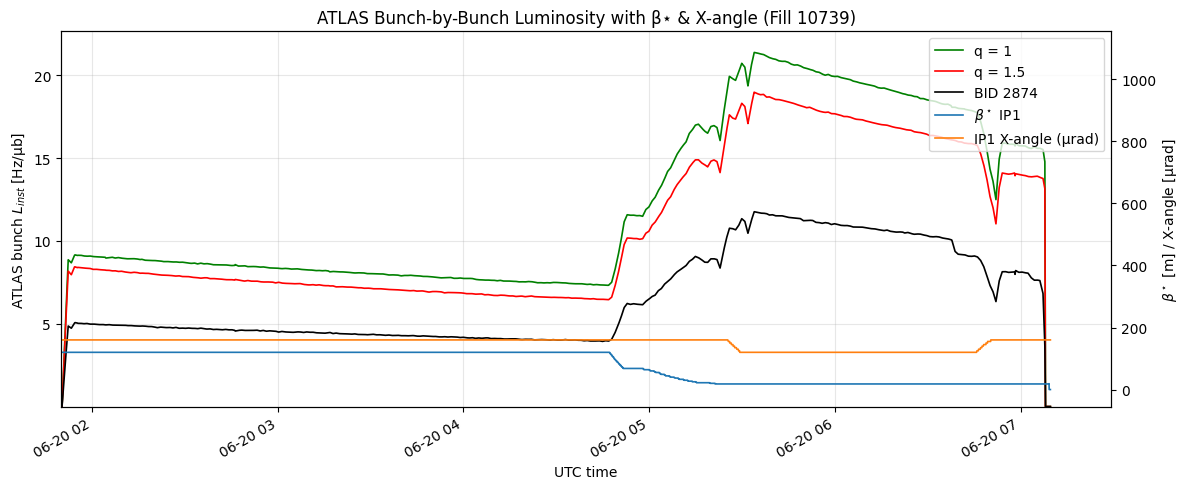

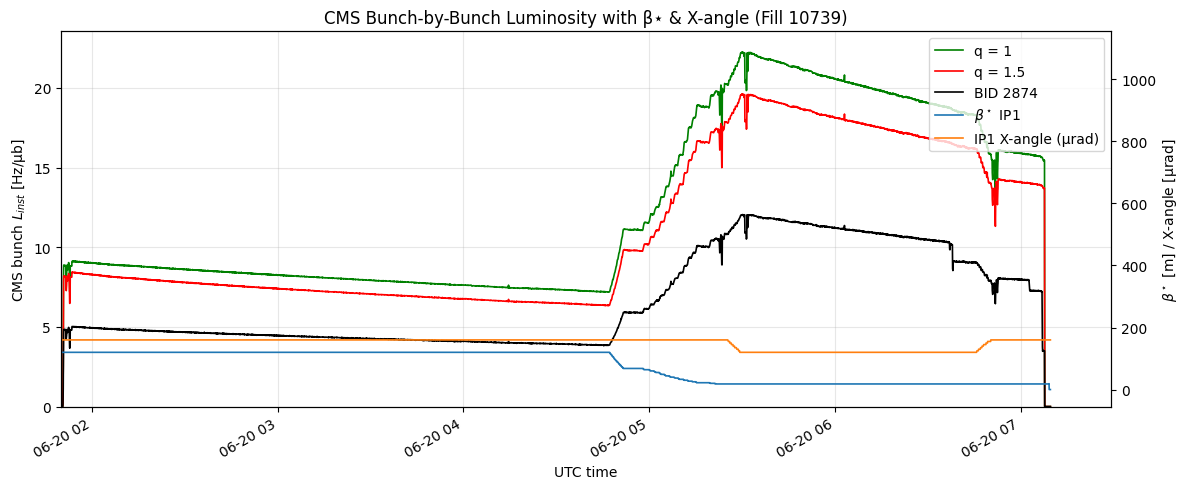

In [38]:

# --- Plot for ATLAS average luminosities + optics
fig1, ax1 = plt.subplots(figsize=(12, 5))
for label, bids in group_defs.items():
    series = atlas_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ax1.plot(series.index, series.values, label=label, color=colours[label], linewidth=1.2)
ax1.set_xlabel("UTC time")
ax1.set_ylabel(r"ATLAS bunch $L_{inst}$ [Hz/μb]")
if dynamic_ylim:
    lo, hi = atlas_sync.min().min(), atlas_sync.max().max()
    ax1.set_ylim(lo * 0.95, hi * 1.05)
ax1.grid(alpha=0.3)
ax1.set_title("ATLAS Bunch-by-Bunch Luminosity with β⋆ & X-angle (Fill 10739)")
ax1.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

ax1b = ax1.twinx()
ax1b.plot(beta_sync.index, beta_sync.values, label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
ax1b.plot(xing_sync.index, xing_sync.values, label=r"IP1 X-angle (μrad)", color="tab:orange", linewidth=1.2)
ax1b.set_ylabel(r"$\beta^\star$ [m] / X-angle [μrad]")

lines1, labels1 = ax1.get_legend_handles_labels()
lines1b, labels1b = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines1b, labels1 + labels1b, loc="upper right")
fig1.autofmt_xdate()
plt.tight_layout()

# --- Plot for CMS average luminosities + optics
fig2, ax2 = plt.subplots(figsize=(12, 5))
for label, bids in group_defs.items():
    series = cms_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ax2.plot(series.index, series.values, label=label, color=colours[label], linewidth=1.2)
ax2.set_xlabel("UTC time")
ax2.set_ylabel(r"CMS bunch $L_{inst}$ [Hz/μb]")
if dynamic_ylim:
    lo, hi = cms_sync.min().min(), cms_sync.max().max()
    ax2.set_ylim(lo * 0.95, hi * 1.05)
ax2.grid(alpha=0.3)
ax2.set_title("CMS Bunch-by-Bunch Luminosity with β⋆ & X-angle (Fill 10739)")
ax2.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

ax2b = ax2.twinx()
ax2b.plot(beta_sync.index, beta_sync.values, label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
ax2b.plot(xing_sync.index, xing_sync.values, label=r"IP1 X-angle (μrad)", color="tab:orange", linewidth=1.2)
ax2b.set_ylabel(r"$\beta^\star$ [m] / X-angle [μrad]")

lines2, labels2 = ax2.get_legend_handles_labels()
lines2b, labels2b = ax2b.get_legend_handles_labels()
ax2.legend(lines2 + lines2b, labels2 + labels2b, loc="upper right")
fig2.autofmt_xdate()
plt.tight_layout()

plt.show()


## Intensity

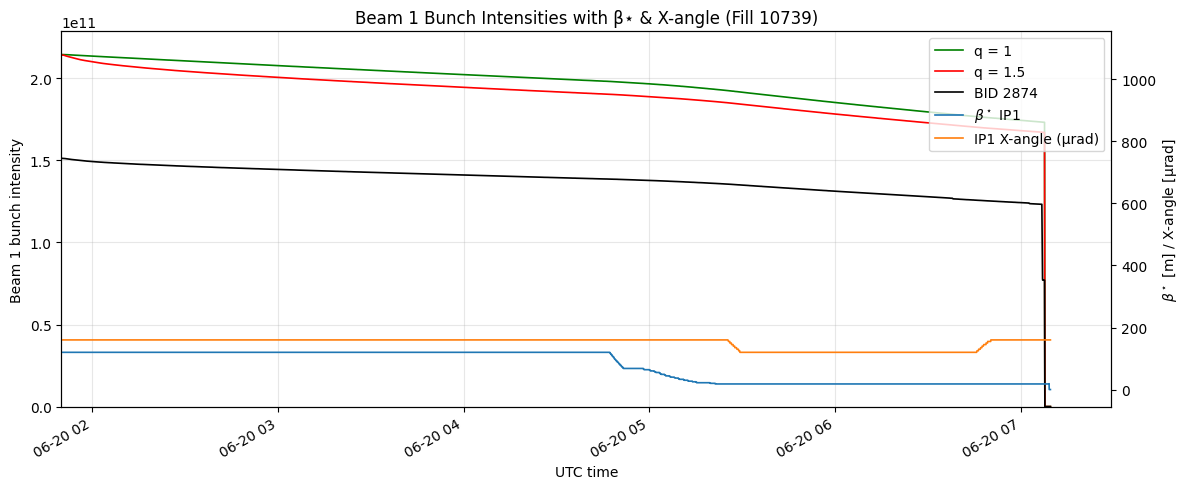

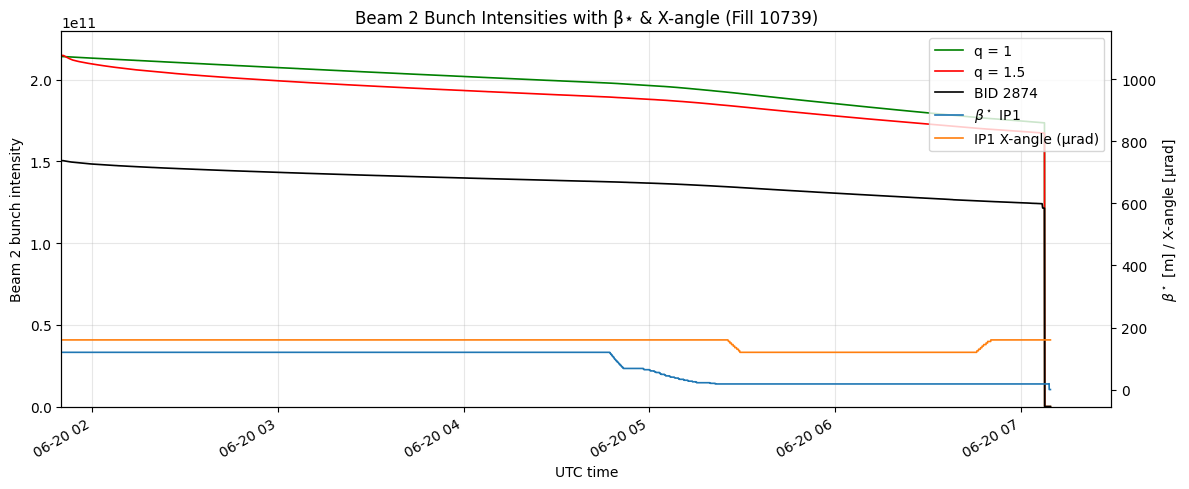

In [40]:
df_b1 = load_bunch_array(LUMI_B1_PV, all_bids)
df_b2 = load_bunch_array(LUMI_B2_PV, all_bids)

for df in (df_b1, df_b2):
    df.dropna(how="all", inplace=True)
    df.index = df.index.round("S")
# Common 1-second time grid
t0 = min(df_b1.index.min(), df_b2.index.min())
t1 = max(df_b1.index.max(), df_b2.index.max())
time_grid = pd.date_range(t0, t1, freq="1S")

b1_sync = (df_b1.reindex(time_grid).interpolate(method="time").ffill().bfill())
b2_sync = (df_b2.reindex(time_grid).interpolate(method="time").ffill().bfill())

beta_sync = beta_1s.reindex(time_grid).interpolate(method="time").ffill().bfill()
xing_sync = xing_1s.reindex(time_grid).interpolate(method="time").ffill().bfill()

# --- Plot for Beam 1 intensities + optics
fig1, ax1 = plt.subplots(figsize=(12, 5))
for label, bids in group_defs.items():
    series = b1_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ax1.plot(series.index, series.values, label=label, color=colours[label], linewidth=1.2)
ax1.set_xlabel("UTC time")
ax1.set_ylabel("Beam 1 bunch intensity")
if dynamic_ylim:
    lo, hi = b1_sync.min().min(), b1_sync.max().max()
    ax1.set_ylim(lo * 0.95, hi * 1.05)
ax1.grid(alpha=0.3)
ax1.set_title("Beam 1 Bunch Intensities with β⋆ & X-angle (Fill 10739)")
ax1.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

ax1b = ax1.twinx()
ax1b.plot(beta_sync.index, beta_sync.values, label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
ax1b.plot(xing_sync.index, xing_sync.values, label=r"IP1 X-angle (μrad)", color="tab:orange", linewidth=1.2)
ax1b.set_ylabel(r"$\beta^\star$ [m] / X-angle [μrad]")

lines1, labels1 = ax1.get_legend_handles_labels()
lines1b, labels1b = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines1b, labels1 + labels1b, loc="upper right")
fig1.autofmt_xdate()
plt.tight_layout()

# --- Plot for Beam 2 intensities + optics
fig2, ax2 = plt.subplots(figsize=(12, 5))
for label, bids in group_defs.items():
    series = b2_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ax2.plot(series.index, series.values, label=label, color=colours[label], linewidth=1.2)
ax2.set_xlabel("UTC time")
ax2.set_ylabel("Beam 2 bunch intensity")
if dynamic_ylim:
    lo, hi = b2_sync.min().min(), b2_sync.max().max()
    ax2.set_ylim(lo * 0.95, hi * 1.05)
ax2.grid(alpha=0.3)
ax2.set_title("Beam 2 Bunch Intensities with β⋆ & X-angle (Fill 10739)")
ax2.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

ax2b = ax2.twinx()
ax2b.plot(beta_sync.index, beta_sync.values, label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
ax2b.plot(xing_sync.index, xing_sync.values, label=r"IP1 X-angle (μrad)", color="tab:orange", linewidth=1.2)
ax2b.set_ylabel(r"$\beta^\star$ [m] / X-angle [μrad]")

lines2, labels2 = ax2.get_legend_handles_labels()
lines2b, labels2b = ax2b.get_legend_handles_labels()
ax2.legend(lines2 + lines2b, labels2 + labels2b, loc="upper right")
fig2.autofmt_xdate()
plt.tight_layout()

plt.show()


## Horizontal Emittance

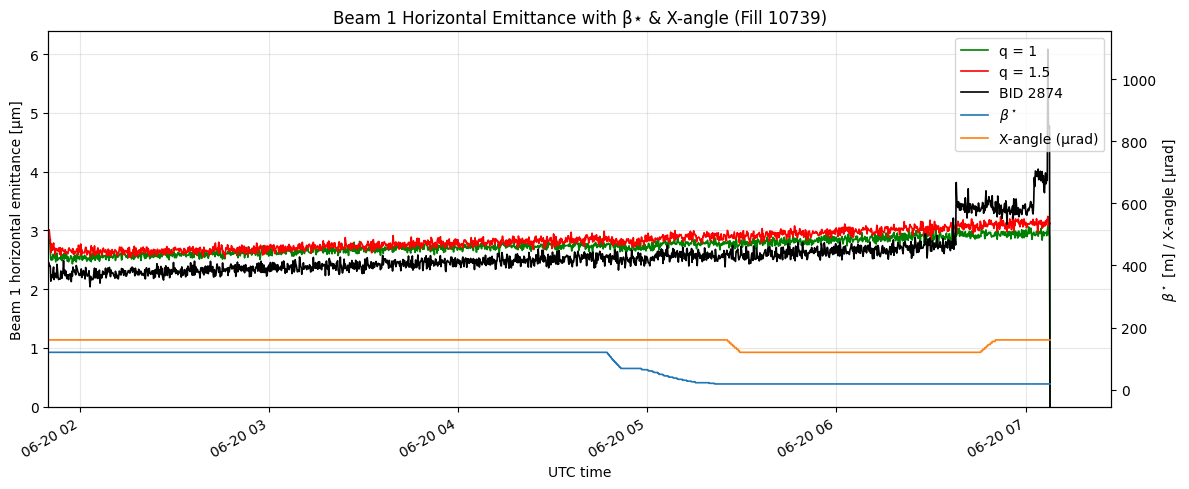

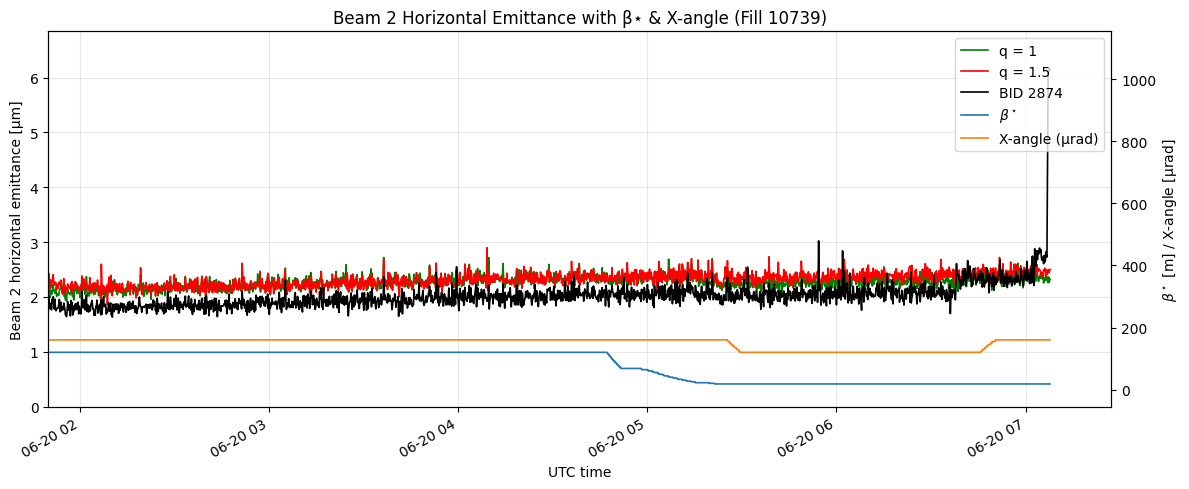

In [42]:
b1_df = load_bunch_array(EMIT_H_B1_PV, all_bids)
b2_df = load_bunch_array(EMIT_H_B2_PV, all_bids)

# --- Build common 1-second time grid
t0 = min(b1_df.index.min(), b2_df.index.min())
t1 = max(b1_df.index.max(), b2_df.index.max())
time_grid = pd.date_range(t0, t1, freq="1S")

# Sync both beams to grid
def sync_to_grid(df):return (df.reindex(time_grid).interpolate(method="time").ffill().bfill())
b1_sync = sync_to_grid(b1_df)
b2_sync = sync_to_grid(b2_df)

beta_sync = beta_1s.reindex(time_grid).interpolate(method="time").ffill().bfill()
xing_sync = xing_1s.reindex(time_grid).interpolate(method="time").ffill().bfill()
# --- Plot Beam 1 horizontal emittance with optics
fig1, ax1 = plt.subplots(figsize=(12, 5))
for label, bids in group_defs.items():
    series = b1_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ax1.plot(series.index, series.values, label=label, color=colours[label], linewidth=1.2)
ax1.set_xlabel("UTC time")
ax1.set_ylabel("Beam 1 horizontal emittance [µm]")
if dynamic_ylim:
    lo, hi = b1_sync.min().min(), b1_sync.max().max()
    ax1.set_ylim(lo * 0.95, hi * 1.05)
ax1.grid(alpha=0.3)
ax1.set_title("Beam 1 Horizontal Emittance with β⋆ & X-angle (Fill 10739)")
ax1.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))
ax1b = ax1.twinx()
ax1b.plot(beta_sync.index, beta_sync.values, label=r"$\beta^\star$", color="tab:blue", linewidth=1.2)
ax1b.plot(xing_sync.index, xing_sync.values, label="X-angle (μrad)", color="tab:orange", linewidth=1.2)
ax1b.set_ylabel(r"$\beta^\star$ [m] / X-angle [μrad]")
lines1, labels1 = ax1.get_legend_handles_labels()
lines1b, labels1b = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines1b, labels1 + labels1b, loc="upper right")
fig1.autofmt_xdate()
plt.tight_layout()

# --- Plot Beam 2 horizontal emittance with optics
fig2, ax2 = plt.subplots(figsize=(12, 5))
for label, bids in group_defs.items():
    series = b2_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ax2.plot(series.index, series.values, label=label, color=colours[label], linewidth=1.2)
ax2.set_xlabel("UTC time")
ax2.set_ylabel("Beam 2 horizontal emittance [µm]")
if dynamic_ylim:
    lo, hi = b2_sync.min().min(), b2_sync.max().max()
    ax2.set_ylim(lo * 0.95, hi * 1.05)
ax2.grid(alpha=0.3)
ax2.set_title("Beam 2 Horizontal Emittance with β⋆ & X-angle (Fill 10739)")
ax2.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))
ax2b = ax2.twinx()
ax2b.plot(beta_sync.index, beta_sync.values, label=r"$\beta^\star$", color="tab:blue", linewidth=1.2)
ax2b.plot(xing_sync.index, xing_sync.values, label="X-angle (μrad)", color="tab:orange", linewidth=1.2)
ax2b.set_ylabel(r"$\beta^\star$ [m] / X-angle [μrad]")
lines2, labels2 = ax2.get_legend_handles_labels()
lines2b, labels2b = ax2b.get_legend_handles_labels()
ax2.legend(lines2 + lines2b, labels2 + labels2b, loc="upper right")
fig2.autofmt_xdate()
plt.tight_layout()

plt.show()


## Verical Emittance


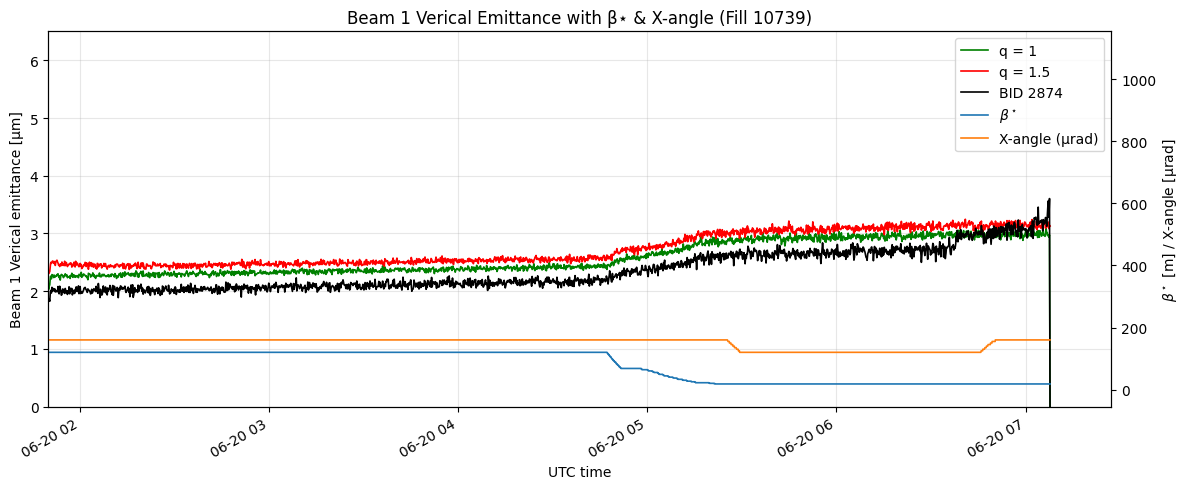

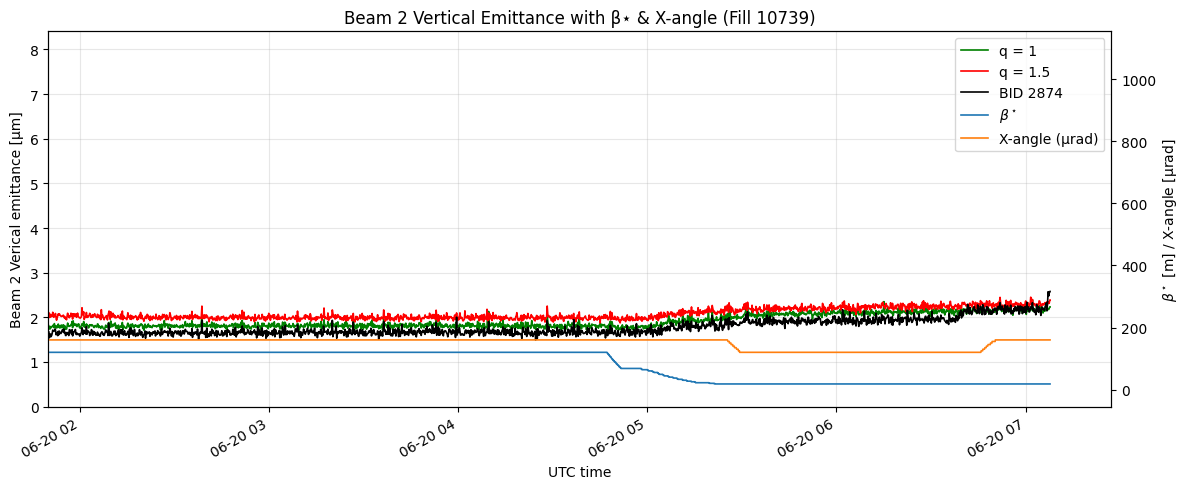

In [45]:
b1_df = load_bunch_array(EMIT_V_B1_PV, all_bids)
b2_df = load_bunch_array(EMIT_V_B2_PV, all_bids)

# --- Build common 1-second time grid
t0 = min(b1_df.index.min(), b2_df.index.min())
t1 = max(b1_df.index.max(), b2_df.index.max())
time_grid = pd.date_range(t0, t1, freq="1S")

# Sync both beams to grid
def sync_to_grid(df):return (df.reindex(time_grid).interpolate(method="time").ffill().bfill())
b1_sync = sync_to_grid(b1_df)
b2_sync = sync_to_grid(b2_df)

beta_sync = beta_1s.reindex(time_grid).interpolate(method="time").ffill().bfill()
xing_sync = xing_1s.reindex(time_grid).interpolate(method="time").ffill().bfill()
# --- Plot Beam 1 horizontal emittance with optics
fig1, ax1 = plt.subplots(figsize=(12, 5))
for label, bids in group_defs.items():
    series = b1_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ax1.plot(series.index, series.values, label=label, color=colours[label], linewidth=1.2)
ax1.set_xlabel("UTC time")
ax1.set_ylabel("Beam 1 Verical emittance [µm]")
if dynamic_ylim:
    lo, hi = b1_sync.min().min(), b1_sync.max().max()
    ax1.set_ylim(lo * 0.95, hi * 1.05)
ax1.grid(alpha=0.3)
ax1.set_title("Beam 1 Verical Emittance with β⋆ & X-angle (Fill 10739)")
ax1.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))
ax1b = ax1.twinx()
ax1b.plot(beta_sync.index, beta_sync.values, label=r"$\beta^\star$", color="tab:blue", linewidth=1.2)
ax1b.plot(xing_sync.index, xing_sync.values, label="X-angle (μrad)", color="tab:orange", linewidth=1.2)
ax1b.set_ylabel(r"$\beta^\star$ [m] / X-angle [μrad]")
lines1, labels1 = ax1.get_legend_handles_labels()
lines1b, labels1b = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines1b, labels1 + labels1b, loc="upper right")
fig1.autofmt_xdate()
plt.tight_layout()

# --- Plot Beam 2 horizontal emittance with optics
fig2, ax2 = plt.subplots(figsize=(12, 5))
for label, bids in group_defs.items():
    series = b2_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ax2.plot(series.index, series.values, label=label, color=colours[label], linewidth=1.2)
ax2.set_xlabel("UTC time")
ax2.set_ylabel("Beam 2 Verical emittance [µm]")
if dynamic_ylim:
    lo, hi = b2_sync.min().min(), b2_sync.max().max()
    ax2.set_ylim(lo * 0.95, hi * 1.05)
ax2.grid(alpha=0.3)
ax2.set_title("Beam 2 Vertical Emittance with β⋆ & X-angle (Fill 10739)")
ax2.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))
ax2b = ax2.twinx()
ax2b.plot(beta_sync.index, beta_sync.values, label=r"$\beta^\star$", color="tab:blue", linewidth=1.2)
ax2b.plot(xing_sync.index, xing_sync.values, label="X-angle (μrad)", color="tab:orange", linewidth=1.2)
ax2b.set_ylabel(r"$\beta^\star$ [m] / X-angle [μrad]")
lines2, labels2 = ax2.get_legend_handles_labels()
lines2b, labels2b = ax2b.get_legend_handles_labels()
ax2.legend(lines2 + lines2b, labels2 + labels2b, loc="upper right")
fig2.autofmt_xdate()
plt.tight_layout()

plt.show()


## All interpolated

In [46]:
BUNCH_PVS = {
    'ATLAS_LUMI': "ATLAS:BUNCH_LUMI_INST",
    'CMS_LUMI'  : "CMS:BUNCH_LUMI_INST",
    'LUMI_B1'   : "LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY",
    'LUMI_B2'   : "LHC.BCTFR.B6R4.B2:BUNCH_INTENSITY",
    'EMIT_H_B1' : "LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_H",
    'EMIT_H_B2' : "LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_H",
    'EMIT_V_B1' : "LHC.BSRT.5R4.B1:BUNCH_EMITTANCE_V",
    'EMIT_V_B2' : "LHC.BSRT.5L4.B2:BUNCH_EMITTANCE_V",
}

# scalar series
SCALAR_PVS = {
    'BETASTAR_IP1': "HX:BETASTAR_IP1",
    'XING_IP1'    : "LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value",
}

# bunch grouping for averaging
BUNCH_GROUPS = {
    "q = 1"  : [20, 500],
    "q = 1.5": [1250, 1800],
}
SOLO_BID = 2874
ALL_BIDS = [*BUNCH_GROUPS["q = 1"], *BUNCH_GROUPS["q = 1.5"], SOLO_BID]

# --- Load functions ---
def load_bunch_array(pv_name: str, bids: list):
    """
    Load a bunch-array PV from Parquet, drop rows where all specified
    bunches are NaN, round index to 1 s, return DataFrame with BIDs.
    """
    raw = dd.read_parquet(DATADIR, columns=[pv_name]).dropna().compute()
    raw.index = pd.to_datetime(raw.index, unit='ns')
    raw.sort_index(inplace=True)
    mat = np.stack(raw[pv_name].values)
    df = pd.DataFrame(mat[:, bids], index=raw.index, columns=[f'B{b}' for b in bids])
    df.dropna(how='all', inplace=True)
    df.index = df.index.round('S')
    return df


def load_scalar_series(pv_name: str):
    """Load a scalar PV, drop NaNs, resample to 1 s bins (mean)."""
    raw = dd.read_parquet(DATADIR, columns=[pv_name]).dropna().compute()
    raw.index = pd.to_datetime(raw.index, unit='ns')
    raw.sort_index(inplace=True)
    return raw[pv_name].astype(float).resample('1S').mean()

# --- Load all PVs ---
bunch_dfs = {key: load_bunch_array(pv, ALL_BIDS) for key, pv in BUNCH_PVS.items()}
scalar_series = {key: load_scalar_series(pv) for key, pv in SCALAR_PVS.items()}

# --- Determine common time grid ---
starts = [df.index.min() for df in bunch_dfs.values()] + [s.index.min() for s in scalar_series.values()]
ends   = [df.index.max() for df in bunch_dfs.values()] + [s.index.max() for s in scalar_series.values()]

t0 = min(starts)
t1 = max(ends)
time_grid = pd.date_range(t0, t1, freq='1S')

# --- Synchronize to grid ---
def sync_df(df: pd.DataFrame):
    return df.reindex(time_grid).interpolate(method='time').ffill().bfill()

def sync_series(s: pd.Series):
    return s.reindex(time_grid).interpolate(method='time').ffill().bfill()

bunch_sync = {key: sync_df(df) for key, df in bunch_dfs.items()}
scalar_sync = {key: sync_series(s) for key, s in scalar_series.items()}

# Now `bunch_sync` and `scalar_sync` contain all PVs interpolated
# to the same 1 s time_series. You can proceed to plot or analyze them.


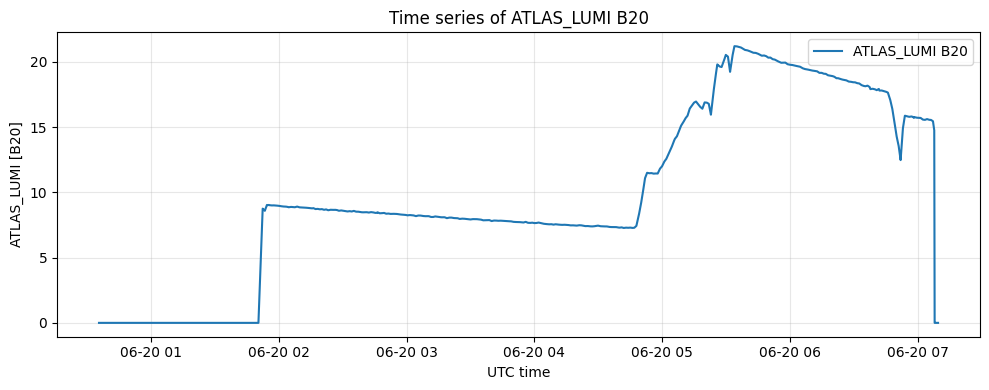

In [47]:
pv_key = 'ATLAS_LUMI'      # one of bunch_sync.keys()
bunch_col = 'B20'          # column in bunch_sync[pv_key]

# 2. Extract the time-aligned Series
data_series = bunch_sync[pv_key][bunch_col]

# 3. Plot the series
posix_times = data_series.index
n_values = data_series.values

plt.figure(figsize=(10, 4))
plt.plot(posix_times, n_values, label=f"{pv_key} {bunch_col}")
plt.xlabel('UTC time')
plt.ylabel(f"{pv_key} [{bunch_col}]")
plt.title(f"Time series of {pv_key} {bunch_col}")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
